In [94]:
from gensim.test.utils import common_texts
from gensim.summarization import keywords, summarize
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser

product_info = pd.read_csv('../data/CatfoodProductInfo.csv')
reviews = pd.read_csv('../data/CatfoodReviewsInfo.csv')
df = reviews.join(product_info.set_index('product'), on='product',how='left')
df = df.dropna(axis=0,how='any')

ninit = len(set(df['product']))
print(f'Prior to filtering out products with less than 50 reviews, there are {ninit} products')

filter = df.groupby('product')['rating'].count() >= 50
df = df[filter[df['product']].values]

nfin = len(set(df['product']))
print(f'After filtering out products with less than 50 reviews, there are {nfin} products')

prod_info_filter = [product in set(df['product']) for product in product_info['product']]
product_info = product_info[prod_info_filter]

brandnames = set(df['brand'].unique())
print(f'There are {len(brandnames)} brands represented across our reviews.')

nprods = len(df.groupby('product'))
nrevs = len(df)
print(f'There are {nrevs} reviews across {nprods} products')
# brandnames

Prior to filtering out products with less than 50 reviews, there are 675 products
After filtering out products with less than 50 reviews, there are 453 products
There are 50 brands represented across our reviews.
There are 36345 reviews across 453 products


In [95]:
# standardize text
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    for brandname in brandnames:
        df[text_field] = df[text_field].str.replace(brandname.lower(),"")

        
    return df

# Function for tokenizing
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens


# Label encode the names

# print(train_documents[0])

df_clean = standardize_text(df,'review_text')

In [96]:
from nltk.tokenize import RegexpTokenizer
pd.set_option('display.width',200)

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
df_clean["tokens"] = df_clean["review_text"].apply(tokenizer.tokenize)

df_clean['tokens'] = df_clean['tokens'].apply(lambda x: ' '.join( [item for item in x if item not in stop_words]))
# df_clean['tokens'] = df_clean['tokens'].apply(lambda x: [item for item in x if item not in stop_words])


all_tokens = [t.split() for t in df_clean['tokens']]
phrases = Phrases(all_tokens)
bigram = Phraser(phrases)
trigram_phrases = Phrases(bigram[all_tokens])
trigram = Phraser(phrases)

df_clean['input'] = df_clean['tokens'].apply(lambda x: bigram[x.split(' ')])


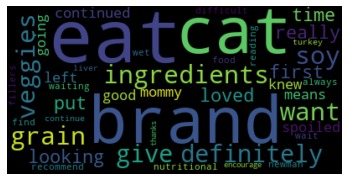

In [97]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Start with one review:
text = df_clean.tokens[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

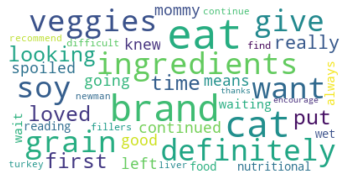

In [98]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
all_tokens = [t for t in df_clean['input']]
flat_list = ', '.join([item for sublist in all_tokens for item in sublist])

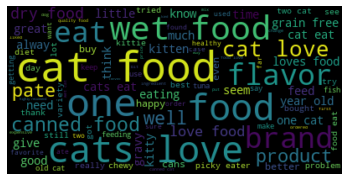

In [25]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(flat_list)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

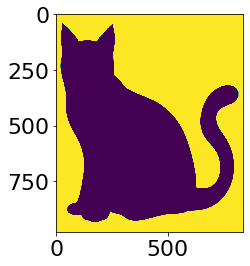

In [99]:
cat_mask_og = np.array(Image.open("silhouette.jpeg"))
plt.imshow(cat_mask_og[:,:,2])

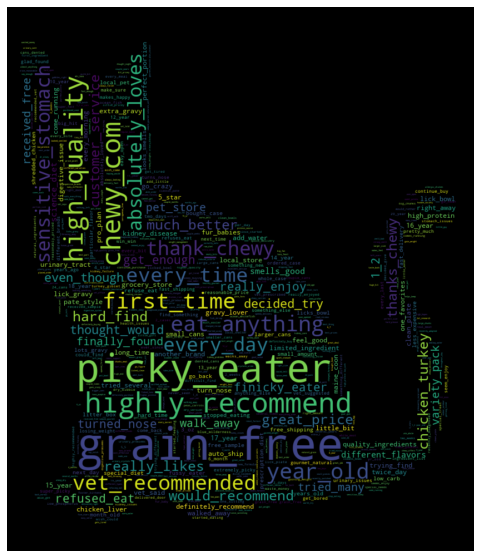

In [101]:
# Create a word cloud image
stopwords = set(STOPWORDS)
stopwords.update(["cat food", "food", "cats love", "cat love", "brand","one","cat","cats","love"])

wc = WordCloud(background_color="black", max_words=1000, mask=cat_mask_og[:,:,0],
                stopwords = stopwords, contour_width=2, contour_color='black')

# Generate a wordcloud
wc.generate(' '.join(input_flat))
# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [58]:
cat_mask = cat_mask_og[:,:,0]

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
transformed_cat_mask = np.ndarray((cat_mask.shape[0],cat_mask.shape[1]), np.int32)

for i in range(len(cat_mask)):
    transformed_cat_mask[i] = list(map(transform_format, cat_mask[i]))

In [59]:
transformed_cat_mask

array([[255, 255, 255, ..., 238, 238, 239],
       [255, 254, 254, ..., 237, 237, 238],
       [255, 254, 254, ..., 237, 237, 238],
       ...,
       [255, 254, 254, ..., 237, 237, 238],
       [254, 254, 254, ..., 237, 237, 237],
       [255, 255, 255, ..., 238, 238, 238]], dtype=int32)

## altair plots

In [11]:
l = flat_list.split(',')

In [12]:
df = pd.DataFrame(l,columns=['word'])

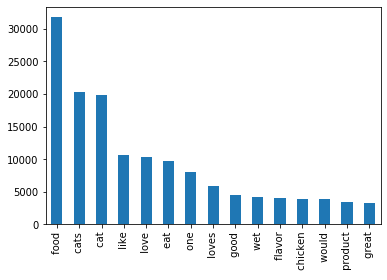

In [13]:
df['word'].value_counts().head(15).plot.bar()

In [48]:
import altair as alt
alt.renderers.enable('notebook')
wordcounts = pd.DataFrame(df['word'].value_counts().reset_index())
wordcounts.columns = ['word', 'count']
wordcounts.head(10)

,word,count
0,food,31812
1,cats,20266
2,cat,19767
3,like,10600
4,love,10367
5,eat,9681
6,one,8048
7,loves,5907
8,good,4548
9,wet,4176


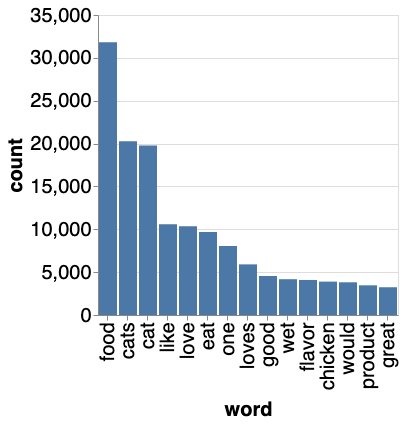

In [63]:
alt.Chart(wordcounts.head(15).sort_values(by='count')).mark_bar().encode(
x=alt.X('word', sort=alt.EncodingSortField(
    field='count',
    order='descending'
        )
    ),
    y='count'
).configure_axis(
    labelFontSize=20,
    titleFontSize=20
)



In [66]:
kw=[]
for x in df_clean['tokens']:
    try:
        kw.append(keywords(x))
    except:
        continue

In [76]:
z=[x.replace('\n', ' ').split() for x in kw]

In [77]:
zflat = [item for sublist in z for item in sublist]

In [78]:
alt.Chart(wordcounts.head(15).sort_values(by='count')).mark_bar().encode(
x=alt.X('word', sort=alt.EncodingSortField(
    field='count',
    order='descending'
        )
    ),
    y='count'
).configure_axis(
    labelFontSize=20,
    titleFontSize=20
)

['eats',
 'cat',
 'eat',
 'definitely',
 'ingredients',
 'veggies',
 'continued',
 'continue',
 'liver',
 'organic',
 'food',
 'foods',
 'eat',
 'siamese',
 'cans',
 'organic',
 'took',
 'canned',
 'cans',
 'like',
 'food',
 'smells',
 'food',
 'brand',
 'clean',
 'little',
 'use',
 'cat',
 'cats',
 'liked',
 'like',
 'time',
 'food',
 'good',
 'profits',
 'profit',
 'love',
 'boys',
 'feeding',
 'different',
 'food',
 'feed',
 'eat',
 'food',
 'foods',
 'great',
 'newman',
 'grain',
 'year',
 'years',
 'picky',
 'stop',
 'food',
 'stopped',
 'adopted',
 'day',
 'dry',
 'hyper',
 'organics',
 'organic',
 'ingredients',
 'food',
 'preserved',
 'preservatives',
 'use',
 'gunk',
 'ending',
 'inside',
 'product',
 'feeding',
 'feed',
 'flavors',
 'organic',
 'organics',
 'year',
 'years',
 'little',
 'goes',
 'long',
 'cat',
 'cats',
 'obviously',
 'food',
 'cat',
 'cats',
 'egg',
 'soon',
 'chicken',
 'attribute',
 'year',
 'loves',
 'time',
 'like',
 'cat',
 'grain',
 'high',
 'quality',

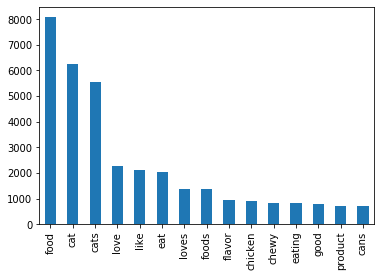

In [83]:
pd.Series(zflat).value_counts().head(15).plot.bar()

In [85]:
input_flat = [item for sublist in df_clean['input'] for item in sublist if '_' in item] 

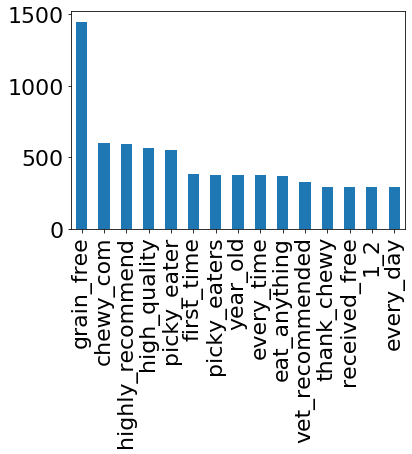

In [92]:
pd.Series(input_flat).value_counts().head(15).plot.bar()
matplotlib.rcParams.update({'font.size': 22})
plt.show()
